In [1]:
"""Importálás"""

import numpy as np
from matplotlib import pyplot as plt
import numba as nb

In [2]:
"""Alap beállítások"""

division = (1000, 2000)
top_left = complex(-2.0, -1.0)
size = complex(4.0, 2.0)
iteration_limit = 50

## Native python

In [3]:
def mandel_native(division, top_left, size, iteration_limit):
    image = [[0 for i in range(division[1])] for j in range(division[0])]   # (1000, 2000) méretű lista kitöltve 0-val
    for i in range(division[1]):
        real = top_left.real + i * size.real / division[1]
        for j in range(division[0]):
            imag = top_left.imag + j * size.imag / division[0]
            c = complex(real, imag)
            z = complex(0, 0)
            iteration = 0

            # fő iteráció:
            while (iteration < iteration_limit) and (abs(z) < 2.0): # (z.real ** 2 + z.imag ** 2 < 4.0):
                z = z ** 2 + c
                iteration += 1
            image[j][i] = -iteration

    return image

image = mandel_native(division, top_left, size, iteration_limit)
%timeit mandel_native(division, top_left, size, iteration_limit)

5.65 s ± 387 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Plotting

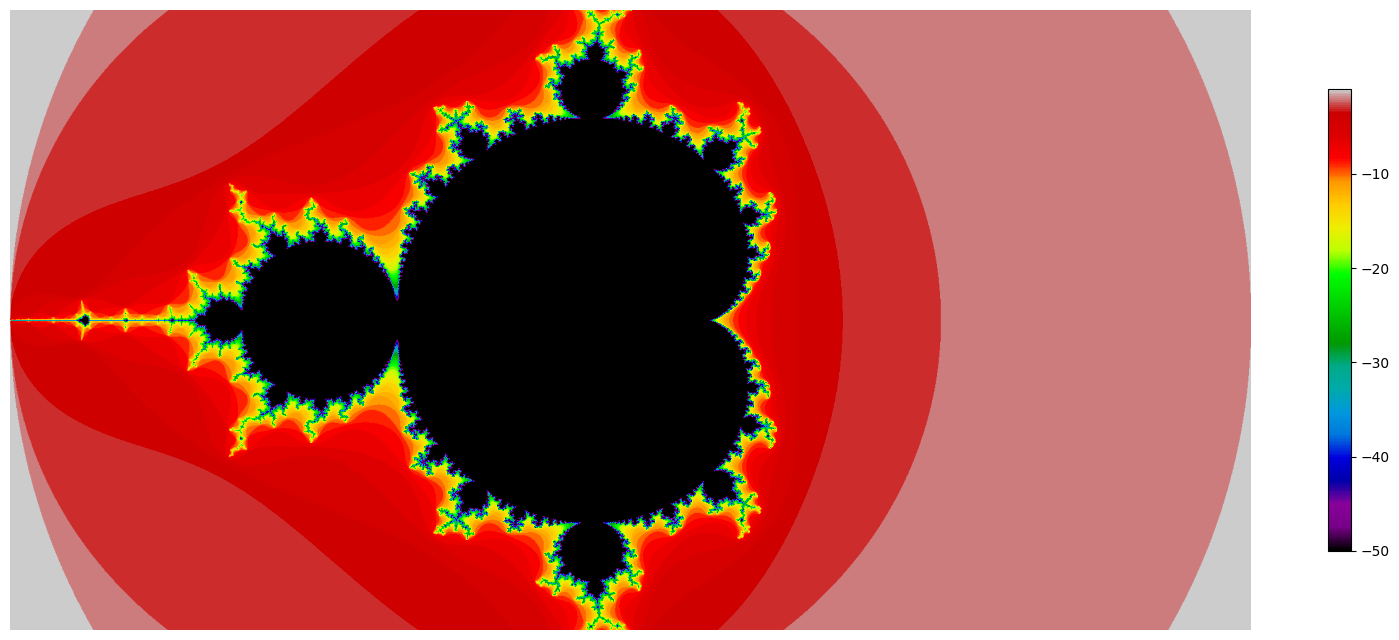

In [4]:
def plot(image, size = 5, title=None):
    fig, ax = plt.subplots(figsize=(2*size, size))
    im = ax.imshow(image, cmap='nipy_spectral')
    cbar = fig.colorbar(im, ax=ax, shrink=0.6)
    ax.axis('off')
    if title != None:
        ax.set_title(title, loc='left')
    plt.show()

plot(image, 10)

## Numpy vektorizáció

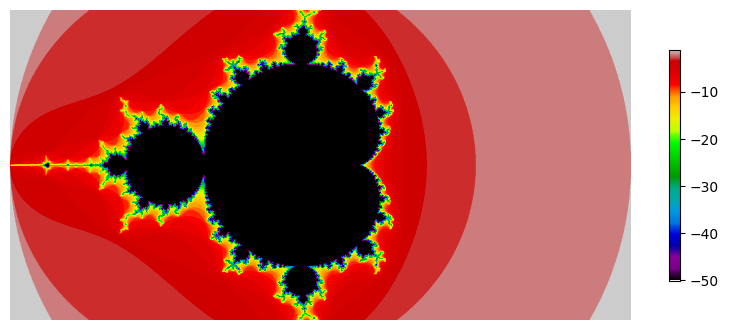

1.34 s ± 54.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
def mandel_vectorize_1D(division, top_left, size, iteration_limit):
    image = np.zeros(division)
    for j in range(division[0]):
        c = np.array(
            [
                complex(
                    top_left.real + i * size.real / division[1],
                    top_left.imag + j * size.imag / division[0]
                ) for i in range(division[1])
            ],  dtype=np.complex128)
        z = np.zeros((division[1]), dtype=np.complex128)
        iteration = np.zeros((division[1]), dtype=np.int64)

        # fő iteráció:
        for _ in range(iteration_limit):
            doit = z.imag ** 2 + z.real ** 2 < 4.0 # abs(z) < 2.0
            z[doit] = z[doit] ** 2 + c[doit]
            iteration[doit] += 1
        image[j] = -iteration

    return image

image = mandel_vectorize_1D(division, top_left, size, iteration_limit)
plot(image)
%timeit mandel_vectorize_1D(division, top_left, size, iteration_limit)

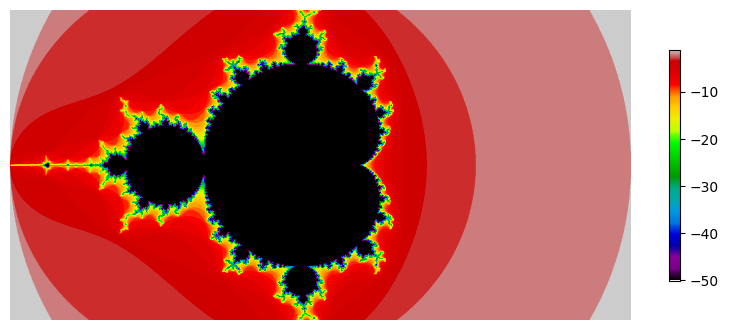

3.06 s ± 19.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
def mandel_vectorize_2D(division, top_left, size, iteration_limit):
    c = np.array(
        [
            [
                complex(
                    top_left.real + i * size.real / division[1],
                    top_left.imag + j * size.imag / division[0]
                ) for i in range(division[1])
            ] for j in range(division[0])
        ], dtype=np.complex128)
    z = np.zeros(division,dtype=np.complex128)
    iteration = np.zeros(division, dtype=np.int64)

    # fő iteráció:
    for _ in range(iteration_limit):
        doit = z.imag ** 2 + z.real ** 2 < 4.0 # abs(z) < 2.0
        z[doit] = z[doit] ** 2 + c[doit]
        iteration[doit] += 1
        
    return -iteration

image = mandel_vectorize_2D(division, top_left, size, iteration_limit)
plot(image)
%timeit mandel_vectorize_2D(division, top_left, size, iteration_limit)

## Numba Just In Time fordító

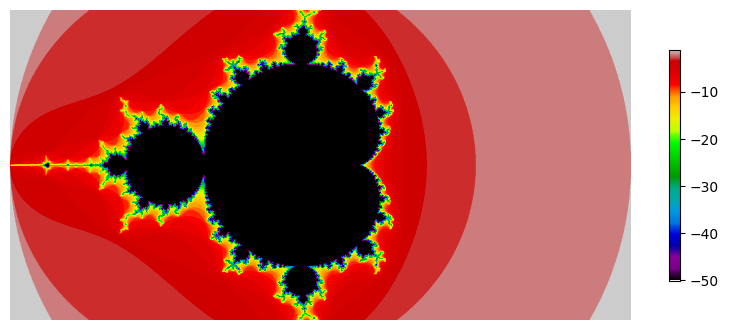

64.3 ms ± 371 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [7]:
@nb.jit
def mandel_jitted(division, top_left, size, iteration_limit):
    image = np.zeros(division)
    for i in range(division[1]):
        real = top_left.real + i * size.real / division[1]
        for j in range(division[0]):
            imag = top_left.imag + j * size.imag / division[0]
            c = complex(real, imag)
            z = complex(0, 0)
            iteration = 0

            # fő iteráció:
            while (iteration < iteration_limit) and (z.real ** 2 + z.imag ** 2 < 4.0): # (abs(z) < 2.0):
                z = z ** 2 + c
                iteration += 1
            image[j][i] = -iteration

    return image

image = mandel_jitted(division, top_left, size, iteration_limit)
plot(image)
%timeit mandel_jitted(division, top_left, size, iteration_limit)

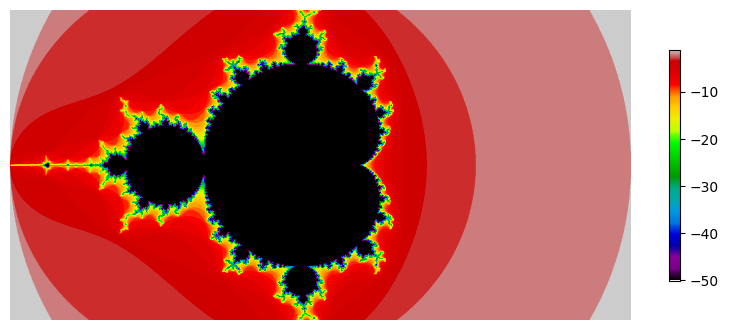

18.4 ms ± 230 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [8]:
@nb.njit(parallel=True)
def mandel_jitted_parallel(division, top_left, size, iteration_limit):
    image = np.zeros(division)
    for i in nb.prange(division[1]):
        real = top_left.real + i * size.real / division[1]
        for j in nb.prange(division[0]):
            imag = top_left.imag + j * size.imag / division[0]
            c = complex(real, imag)
            z = complex(0, 0)
            iteration = 0

            # fő iteráció:
            while (iteration < iteration_limit) and (z.real ** 2 + z.imag ** 2 < 4.0): # (abs(z) < 2.0):
                z = z ** 2 + c
                iteration += 1
            image[j][i] = -iteration

    return image

image = mandel_jitted_parallel(division, top_left, size, iteration_limit)
plot(image)
%timeit mandel_jitted_parallel(division, top_left, size, iteration_limit)

## Multiprocessing párhuzamosítás

In [9]:
import mandelbrot
import importlib
importlib.reload(mandelbrot)

<module 'mandelbrot' from 'd:\\OneDrive - Budapesti Műszaki és Gazdaságtudományi Egyetem\\BME-6\\Python HPC\\mandelbrot.py'>

In [10]:
from multiprocessing import Pool, cpu_count
pool = Pool(processes=cpu_count(), maxtasksperchild=1000)
print(f'magok száma: {cpu_count()}')

magok száma: 16


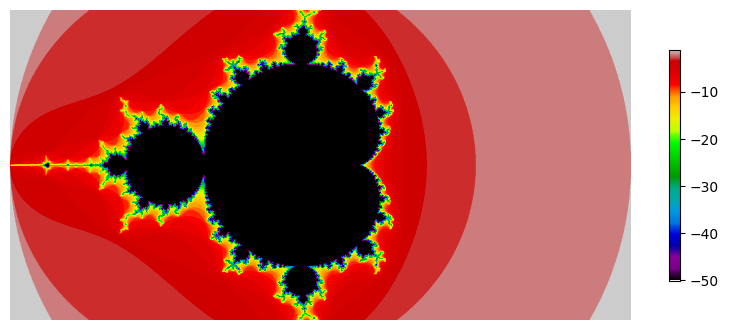

57.4 ms ± 665 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [11]:
def mandel_multiproc(division, top_left, size, iteration_limit):
    image = np.zeros(division, dtype=np.int64)
    arguments = [(j, division, top_left, size, iteration_limit)  for j in range(division[0])]
    rows = pool.starmap(mandelbrot.compute_row, arguments)
    for j, row in enumerate(rows):
        image[j] = row

    return image

image = mandel_multiproc(division, top_left, size, iteration_limit)
plot(image)
%timeit mandel_multiproc(division, top_left, size, iteration_limit)

In [12]:
numba_times = []
multiprocessing_times = []
iteration_limits = [50, 100, 200, 400, 800, 1600]
pool = Pool(processes=cpu_count())
mandel_multiproc(division, top_left, size, 50)

for iteration_limit in iteration_limits:
    print(f'{iteration_limit=}')
    print('    multiprocessing:\n        ', end='')
    time = %timeit -o mandel_multiproc(division, top_left, size, iteration_limit)
    multiprocessing_times.append(time.average)
    print('    numba:\n        ', end='')
    time = %timeit -o mandel_jitted_parallel(division, top_left, size, iteration_limit)
    numba_times.append(time.average)

iteration_limit=50
    multiprocessing:
        56.6 ms ± 589 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
    numba:
        18 ms ± 73.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
iteration_limit=100
    multiprocessing:
        59.9 ms ± 672 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
    numba:
        31.3 ms ± 732 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
iteration_limit=200
    multiprocessing:
        53.3 ms ± 526 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
    numba:
        57.2 ms ± 426 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
iteration_limit=400
    multiprocessing:
        62 ms ± 348 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
    numba:
        110 ms ± 1.62 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
iteration_limit=800
    multiprocessing:
        86.7 ms ± 925 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
    numba:
        205 ms ± 2.33 ms per loop (mean ±

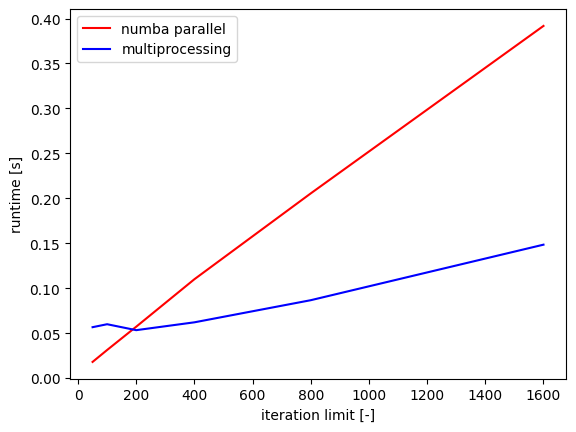

In [13]:
plt.plot(iteration_limits, numba_times, color='r', label='numba parallel')
plt.plot(iteration_limits, multiprocessing_times, color='b', label='multiprocessing')
plt.legend()
plt.xlabel('iteration limit [-]')
plt.ylabel('runtime [s]')

plt.show()

## Interaktív kirajzolás

In [14]:
%matplotlib inline
from time import time
import ipywidgets as widget
from IPython.display import display

# Pozíció reset
top_left = complex(-2.0, -1.0)
size = complex(4.0, 2.0)
iteration_limit = 32

# Plotoló függvény
out = widget.Output()

def plot(image, size = 6, title=None):
    with out:
        out.clear_output(True)
        plt.figure(figsize=(2*size, size))
        plt.imshow(image, cmap='nipy_spectral')
        plt.axis('off')
        if title != None:
            plt.title(title, loc='left')
        plt.show()

image = mandel_jitted_parallel(division, top_left, size, iteration_limit) # <----
plot(image, title=f'{iteration_limit=}')

# Gombok létrehozása
layout = dict(width='80px', height='80px')
style = dict(font_weight='bold', font_size='24px')
buttons = [
    widget.Button(description='^', layout=layout, style=style),
    widget.Button(description='<', layout=layout, style=style),
    widget.Button(description='>', layout=layout, style=style),
    widget.Button(description='v', layout=layout, style=style),
    widget.Button(description='+', layout=layout, style=style),
    widget.Button(description='-', layout=layout, style=style),
    widget.Button(description='/\\', layout=layout, style=style),
    widget.Button(description='\\/', layout=layout, style=style),
    widget.Button(description='o', layout=layout, style=style),
]

# Grid létrehozása
grid = widget.GridspecLayout(3, 6,  height='300px', width='600px')
# Ráhejezés a gridre
grid[0, 4] = buttons[0]
grid[1, 3] = buttons[1]
grid[1, 5] = buttons[2]
grid[2, 4] = buttons[3]
grid[0, 1] = buttons[4]
grid[2, 1] = buttons[5]
grid[0, 0] = buttons[6]
grid[2, 0] = buttons[7]
grid[1, 4] = buttons[8]

# On_click események
def on_click(button):
    global iteration_limit
    global top_left
    global size

    if button.description=='/\\':
        if iteration_limit < 4096:
            iteration_limit *= 2

    elif button.description=='\\/':
        if 8 < iteration_limit:
            iteration_limit /= 2
            iteration_limit = int(iteration_limit)

    elif button.description=='+':
        size = complex(0.5 * size.real, 0.5 * size.imag)
        top_left = complex(top_left.real + 0.5 * size.real, top_left.imag + 0.5 * size.imag)

    elif button.description=='-':
        top_left = complex(top_left.real - 0.5 * size.real, top_left.imag - 0.5 * size.imag)
        size = complex(2.0 * size.real, 2.0 * size.imag)

    elif button.description=='^':
        top_left = complex(top_left.real, top_left.imag - 0.25 * size.imag)

    elif button.description=='v':
        top_left = complex(top_left.real, top_left.imag + 0.25 * size.imag)

    elif button.description=='<':
        top_left = complex(top_left.real - 0.25 * size.imag, top_left.imag)

    elif button.description=='>':
        top_left = complex(top_left.real + 0.25 * size.imag, top_left.imag)

    elif button.description=='o':
        top_left = complex(-2.0, -1.0)
        size = complex(4.0, 2.0)
        iteration_limit = 32


    start = time()
    image = mandel_multiproc(division, top_left, size, iteration_limit) # <----
    end = time()
    plot(image, title=f'{iteration_limit=}, render_time={(end-start): .2f} [s]')

for button in buttons:
    button.on_click(on_click)

# Megjelenítés
display(grid)
display(out)

GridspecLayout(children=(Button(description='^', layout=Layout(grid_area='widget001', height='80px', width='80…

Output()